In [1]:
from games.game import SymmetricNPlayerGame
from wrapper import GameDynamicsWrapper
from wrapper import VariedGame
from dynamics.replicator import Replicator
from dynamics.wright_fisher import WrightFisher
from dynamics.moran import Moran
%matplotlib inline

现在我们将使用DyPy模拟一群玩家进行囚徒困境的游戏，看看自然选择是否有利于叛逃。要做到这一点，我们首先要设置游戏。这涉及到指定策略、平衡点和与之相关的报酬矩阵。以下16行代码是用来准备博弈的

给定代码定义了一个名为 SymmetricNPlayerGame 的类，它继承自 Game 类。该类提供了一个N人博弈的逻辑，其中每个玩家从相同的策略集中选择。

类构造函数接受几个参数：

payoff_matrix：一个二维列表，表示每个玩家的收益矩阵。由于这是对称博弈，因此这个矩阵应该是对称的。
n：游戏中玩家类型的数量，对于一个两人对称博弈来说，通常为1。
bias_strength、bias_scale 和 equilibrium_tolerance 为可选参数，分别表示偏差强度、偏差规模和平衡容忍度。
在构造函数中，如果 STRATEGY_LABELS 不为空，会将其复制n次作为新的 STRATEGY_LABELS。然后，将给定的 payoff_matrix 转置后追加到原矩阵后面，构成一个包含两个矩阵的列表。最后，通过调用父类的构造函数，初始化 SymmetricNPlayerGame 的实例。

In [23]:
# Class that defines the Prisoners’ Dilemma game.
class PrisonersDilemma(SymmetricNPlayerGame):
    DEFAULT_PARAMS = dict(R = 3, S = 0, T = 5, P = 1, bias_strength = 0)# List of strategies
    STRATEGY_LABELS = ('合作者', '反叛者')# List of equilibria
    EQUILIBRIA_LABELS = ('合作', '反叛')
    
    def __init__(self, R, S, T, P, bias_strength): #Define the payoff matrix
        payoff_matrix = ((R, S), (T, P))
        super(PrisonersDilemma, self).__init__(payoff_matrix, 1, bias_strength)
        
    @ classmethod
    # Function that defines the equilibria
    def classify(cls, params, state, tolerance):
        threshold = 1 - tolerance
        if state[0][0] > threshold:
            return 0# Cooperate
        elif state[0][1] > threshold:
            return 1# Defect
        else :
            return super(PrisonersDilemma, cls).classify(params, state, tolerance)

In [3]:
print(PrisonersDilemma)

<class '__main__.PrisonersDilemma'>


这段代码定义了一个名为 PD 的类，它继承自 SymmetricNPlayerGame 类。PD 类代表了一个囚徒困境博弈。

类变量 `DEFAULT_PARAMS` 是一个字典，包含囚徒困境博弈中的四个参数 R、S、T 和 P，以及偏见强度 bias_strength 和偏见规模 bias_scale。这些参数将在 `__init__` 方法中使用。

`STRATEGY_LABELS` 是一个元组，它包含博弈中使用的两种策略标签：“合作”和“背叛”。

`EQUILIBRIA_LABELS` 是一个元组，它包含两种平衡状态的标签：“合作”和“背叛”。

`__init__` 方法使用给定的 R、S、T、P、bias_strength 和 bias_scale 参数初始化一个 2x2 的元组 `payoff_matrix`，并将其传递给父类 SymmetricNPlayerGame 的构造函数。同时，传递了参数1表示仅有一种类型的玩家在游戏中参与。

`classify` 方法根据给定的参数和当前状态，判断当前策略处于哪个平衡状态。当玩家采取“合作”时，收益为 R（reward）；当玩家采取“背叛”时，收益为 T（temptation）。当对手采取“合作”时，收益为 S（sucker's payoff）；当对手采取“背叛”时，收益为 P（punishment）。判断状态的方法是，如果玩家采取“合作”策略的比例大于等于 
$$
1-\text{tolerance}
$$
，则返回0，表示当前处于“合作”状态；如果玩家采取“背叛”策略的比例大于等于
$$
1-\text{tolerance}
$$
，则返回1，表示当前处于“背叛”状态；否则，调用父类 SymmetricNPlayerGame 的 `classify` 方法进行分类。

In [4]:
# import matplotlib
# print(matplotlib.matplotlib_fname())

## 对博弈动态的单一模拟

In [5]:
#导入中文字体包
from matplotlib import font_manager
font_manager.fontManager.addfont('/Users/pu/opt/anaconda3/lib/python3.8/site-packages/matplotlib/mpl-data/fonts/ttf/SimHei.ttf')

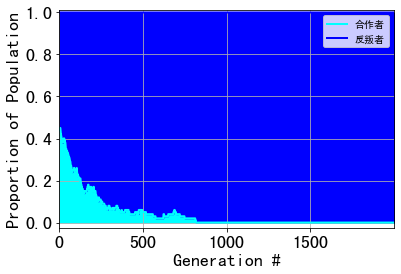

In [6]:
# 使用Moran迭代2000次的策略

s = GameDynamicsWrapper(PrisonersDilemma, Moran)
s.simulate(num_gens = 2000, pop_size = 100, graph = dict(area = True, options = ['smallfont']))
# s.simulate(num_gens=100,pop_size=100,graph=dict(area=True,options=['smallfont']))

在许多情况下，我们希望多次运行模拟，以检查在初始条件发生变化或由于动态的固有随机性而产生的结果的稳健性。
博弈也可能有多个均衡，在这种情况下，用户可能会对人口在每个均衡中度过的迭代的比例感兴趣。
由于这些原因，我们提供了 "simulate many "的方法，在这个方法中，模拟的多次迭代被运行，并返回每个结果均衡的频率。
如果系统不在使用分类命令确定的状态的 "容忍度 "范围内，模拟会返回 "未分类"。
当进行多次模拟时，它们会自动在所有可用的核心上并行化。
我们现在使用 "simulate many "和随机的Moran  dynamic，以表明即使在存在随机性的情况下，玩囚徒困境的群体也会稳定在叛逃状态。

## 博弈的动态模拟多次迭代 Multiple iterations of a simulation of the game’s dynamic

simulate_many这段代码是一个类的方法，用于模拟博弈，多次迭代，计算出每个策略均衡出现的频率。具体来说，它将调用simulate方法num_iterations次，每次模拟num_gens代，然后平均频率，以得出策略均衡的结果。该方法在计算时进行了并行化处理。

参数说明：

num_iterations：模拟的次数。
num_gens：每次模拟运行的代数。
pop_size：总人口数量。
start_state：每个玩家策略的初始分布，可以是列表或None。
graph：图形的类型，如果不需要图形则为false。
histogram：如果为True，则绘制最终人口数量的直方图。graph和histogram不能同时为True。
return_labeled：是否应对返回的归类均衡分布进行标记。
parallelize：是否并行计算，默认为True。
class_end：如果为False，则对所有代进行归类，如果为True，则只对最后一代进行归类。
frac_invasions：给定的模拟是否计算某一策略的侵略程度分数。
strategy_indx：要计算侵略程度分数的策略的索引。
返回值是每个策略均衡出现的频率。

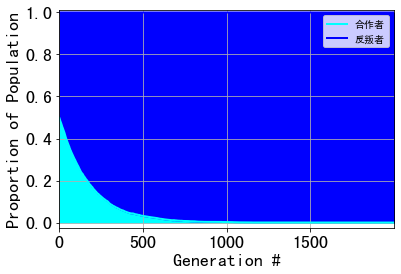

{'反叛': 1.0}

In [7]:
# 使用Moran迭代2000次，平均100次记录一次

s = GameDynamicsWrapper(PrisonersDilemma, Moran)
s.simulate_many(num_iterations = 100, num_gens = 2000, pop_size = 100, graph = dict(area = True, options = ['smallfont']))

## 近似固定概率 Approximating Fixation Probabilities 

以下几行代码可用于近似计算囚徒困境中 "反叛者"的发生概率，tolerance设置为0。
囚徒困境中策略的失效概率可以通过分析计算出来（Hindersin等人（2019））。
对于我们模拟中使用的报酬和选择强度，"缺陷 "的失效概率为0.8，这与通过模拟得到的近似值非常一致。

In [8]:

s = GameDynamicsWrapper(PrisonersDilemma, Moran)
s.frac_invasions(num_iterations = 1000, num_gens = 2000, pop_size = 100, strategy_indx = 1)# Index of strategy‘ Defect’

'Fraction of runs where the required strategy dominated the population = 0.79'

## 不同参数的影响Eﬀect of varying parameters

我们提供 "vary "方法来分析改变一个或多个与动力学或游戏相关的参数的影响。对于每一个被改变的参数值，都要进行多次迭代模拟，并记录每个平衡的最终频率。输出是这些最终频率与不同参数的函数关系图。作为一个例子，我们改变了囚徒困境游戏中的报酬值T（1, 2, ..., 10）。
下图显示了在固定的R=3的情况下，改变T的策略比例的均衡情况。当T>R时，该游戏是囚徒困境，因此，我们看到一旦如此，动态就会收敛为叛逃。


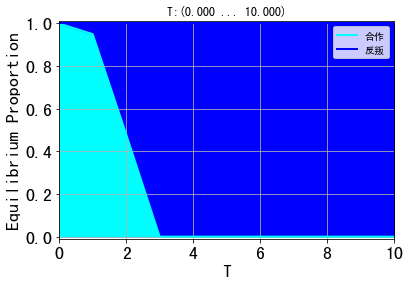

In [9]:
# 每个模拟运行了4000代，每个T值（1，2，...，10）平均进行了100次迭代。
#我们在所有的模拟中使用了100个种群规模，囚徒困境中的报酬设定为R=3，S=0，T=5和P=1。

s = VariedGame(PrisonersDilemma, Moran)
s.vary(game_kwargs = {'T': [0, 10, 10]}, num_gens = 4000, num_iterations = 100, graph = dict(area = True, options = ['smallfont']))

## 频率偏差模仿 Frequency   Biased   Imitation

### 囚徒困境中的顺从主义 Conformism  in  Prisoners’  Dilemma

顺应主义是一种社会学习策略，参与者通过模仿大多数人学习策略（R.Boyd和P.J.Richerson，1985）。
将顺应主义的影响添加到迄今为止所考虑的基于报酬的学习中，有助于在某些条件下稳定合作。
我们可以通过VariedGame类来模拟囚徒困境游戏的这个系统，并改变顺应论的强度来重现（Molleman等人，2013）的结果。
模拟中使用的所有参数见SI。

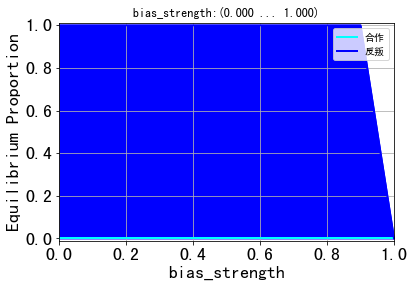

In [10]:

s = VariedGame(PrisonersDilemma, WrightFisher)
# s = VariedGame(PrisonersDilemma, Moran)
s.vary(game_kwargs = {'bias_strength': [0, 1, 10]}, num_gens = 100, num_iterations = 100, parallelize = True, graph = dict(area = True, options = ['smallfont']))

## 群体选择 Group   Selection

一个博弈的动态可能不再收敛到纳什均衡，在存在群体选择的情况下，在某些条件下合作比叛逃更有利。

### 囚徒困境中的群体选择

在保持总人口不变的情况下，改变种群数量和种群大小，在玩囚徒困境（Wright-Fisher动力学）的种群中出现平衡的次数比例。
种群的数量从1到25不等。在每个种群数量下，模拟运行了100代，每代平均100次迭代。
种群选择的 "比率 "为0.2。两次模拟的种群大小都被设定为100。


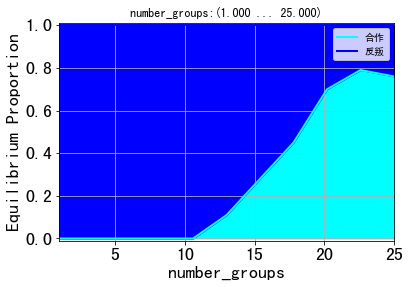

In [11]:

s = VariedGame(PrisonersDilemma, WrightFisher, dynamics_kwargs = {'rate': 0.2})
s.vary(dynamics_kwargs = {'number_groups': [1, 25, 10]}, num_gens = 100, num_iterations = 100, graph = dict(area = True, options = ['smallfont']))

## Rock-Paper-Scissors 石头剪刀布

到目前为止，我们已经分析了囚徒困境的动态，在均衡状态下，所有玩家都玩D。
现在我们简要介绍一下石头-剪子-布（RPS）游戏的动态，对于这种游戏，唯一的均衡状态是三分之一的玩家玩石头，三分之一玩纸，三分之一玩剪子。
对该游戏动态的分析揭示了均衡分析所不能揭示的有趣的东西：人口经常循环一段时间，甚至永远循环，这取决于赢得与输掉一轮游戏的报酬的相对大小（Hoﬀman等人，2015）。
我们在图3中使用包括突变在内的随机过程以及 "模拟 "和 "多次模拟 "方法来说明这一点（代码和所用参数见SI）。
任何具有循环支配的对称三策略博弈都是RPS博弈的特征（Nowak（2006））


In [12]:

class RSP(SymmetricNPlayerGame): 
    DEFAULT_PARAMS = dict(a1 = 0.2, a2 = 0.2, a3 = 0.2, b1 = 2, b2 = 2, b3 = 2)
    STRATEGY_LABELS = ('石头', '布', '剪刀')
    EQUILIBRIA_LABELS = ('Nash', )
    
    def __init__(self, a1, a2, a3, b1, b2, b3): 
        payoff_matrix = ((0, -a2, b3), (b1, 0, -a3), (-a1, b2, 0))
        super(RSP, self).__init__(payoff_matrix, 1)
        
    @ classmethod
    def classify(cls, params, state, tolerance): 
        
        threshold = 1 / 3
        pop_rock = state[0][0]
        pop_paper = state[0][1]
        pop_scissors = state[0][2]
        
        if abs(pop_rock - threshold) <= tolerance and abs(pop_paper - threshold) <= tolerance and abs(pop_scissors - threshold) <= tolerance: 
            return 0 # Nash
        else :
            return super(RSP, cls).classify(params, state, tolerance)

如果种群收敛到纳什均衡，"classify "方法返回 "Nash"，否则返回 "未分类"。我们将tolerance设置为0.03。用于生成模拟的单次迭代的代码:

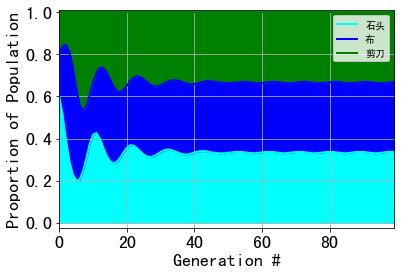

In [13]:

s = GameDynamicsWrapper(RSP, WrightFisher)
s.simulate(num_gens = 100, pop_size = 500, start_state = [[[300, 100, 100]]], graph = dict(area = True, options = ['smallfont']))

我们用这个起始状态来说明，即使动力学从平衡点开始，固定点也是稳定的。在有突变的情况下，用于生成模拟的多次迭代的代码。

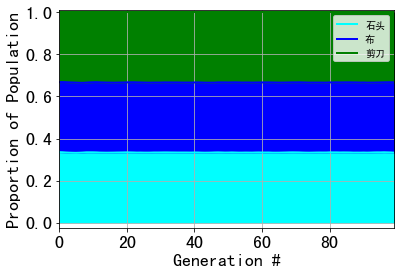

{'Nash': 1.0}

In [14]:

s = GameDynamicsWrapper(RSP, WrightFisher, dynamics_kwargs = {'mu': 0.03})
s.simulate_many(num_iterations = 500, num_gens = 100, pop_size = 500, graph = dict(area = True, options = ['smallfont']))

## 重复博弈

In [15]:



class ReactivePD(SymmetricNPlayerGame):
    """ A class used to represent a symmetric game, where the players are playing 4 reactive strategies associated
    with the Prisoners' Dilemma.
    """
    DEFAULT_PARAMS = dict(R=3, T=5, S=0, P=1, bias_strength=0)
    STRATEGY_LABELS = ('ALLD', 'ALLC', 'TFT', 'GTFT')
    EQUILIBRIA_LABELS = ('ALLD', 'ALLC', 'TFT', 'GTFT')

    def __init__(self, R, T, S, P, bias_strength):

        self.R = R; self.T = T; self.S = S; self.P = P
        
        # 函数定义了4个变量p1、q1、p2、q2、p3、q3和p4、q4，分别对应四种响应策略。这些变量的值被设置为0、0、1、1、1、0和1、1/3。

        p1 = 0; q1 = 0
        p2 = 1; q2 = 1
        p3 = 1; q3 = 0
        p4 = 1; q4 = 1/3

        '''
        这段代码是定义了一个 4x4 的支付矩阵（payoff_matrix），其中矩阵中的每个元素都是通过调用类中的 payoff 方法得到的。
        payoff 方法的参数是由 p 和 q 组成的四元组，每个四元组都是矩阵中的一个元素，
        比如 (p1, q1, p1, q1) 就是矩阵的第一行第一列的元素，(p1, q1, p2, q2) 就是矩阵的第一行第二列的元素。
        这个支付矩阵是博弈论中重要的概念，用于描述参与者在不同行动组合下的利润或收益。
        ''' 
        payoff_matrix = ((self.payoff(p1,q1,p1,q1),self.payoff(p1,q1,p2,q2),self.payoff(p1,q1,p3,q3),self.payoff(p1,q1,p4,q4)),
                         (self.payoff(p2,q2,p1,q1),self.payoff(p2,q2,p2,q2),self.payoff(p2,q2,p3,q3),self.payoff(p2,q2,p4,q4)),
                         (self.payoff(p3,q3,p1,q1),self.payoff(p3,q3,p2,q2),self.payoff(p3,q3,p3,q3),self.payoff(p3,q3,p4,q4)),
                         (self.payoff(p4,q4,p1,q1),self.payoff(p4,q4,p2,q2),self.payoff(p4,q4,p3,q3),self.payoff(p4,q4,p4,q4)))


        super(ReactivePD, self).__init__(payoff_matrix, 2,bias_strength)

    
    '''
    这段代码定义了一个函数 payoff，该函数接受4个参数：p1，q1，p2，q2。
    函数主要用于计算矩阵中的每个单元格的期望收益值。
    在函数中，首先计算了r1和r2，然后使用这些值计算s1和s2。
    如果q1和q2都等于0，则s1和s2都被设置为0，否则根据给定的公式计算s1和s2。
    然后，使用给定的R，T，S和P系数计算期望值E，并将其返回。
    '''
    def payoff(self,p1,q1,p2,q2):
        r1 = p1 - q1
        r2 = p2 - q2

        if q1 == 0 and q2 == 0:

            s1 = 0
            s2 = 0

        else:

            s1 = (q2*r1 + q1)/(1-(r1*r2))
            s2 = (q1*r2 + q2)/(1-(r1*r2))

        E = self.R * s1 * s2 + self.S * s1 * (1-s2) + self.T * (1-s1)*s2 + self.P * (1-s1) * (1-s2)
        return E

    @classmethod
    def classify(cls, params, state, tolerance):
        threshold = 1 - tolerance

        if state[0][0] >= threshold:
            return 0#ALLD
        elif state[0][1] >= threshold:
            return 1#ALLC
        elif state[0][2] >= threshold:
            return 2#TFT
        elif state[0][3] >= threshold:
            return 3#GTFT
        else:
            return super(ReactivePD, cls).classify(params, state, tolerance)


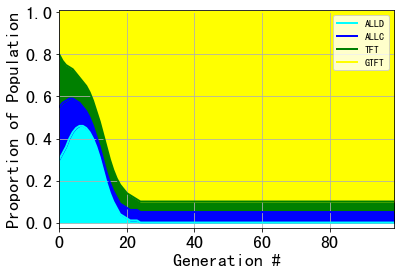

In [16]:

s = GameDynamicsWrapper(ReactivePD, Replicator)
s.simulate(num_gens = 100, pop_size = 100, graph = dict(area = True, options = ['smallfont']))

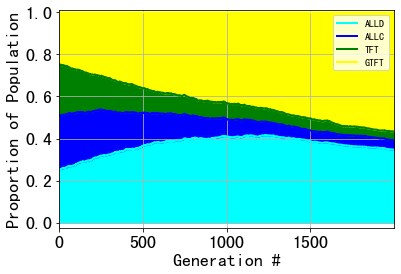

{'ALLD': 0.26, 'GTFT': 0.34, 'Unclassified': 0.4}

In [17]:


s = GameDynamicsWrapper(ReactivePD, Moran)
s.simulate_many(num_iterations = 100, num_gens = 2000, pop_size = 100, class_end = True, graph = dict(area = True, options = ['smallfont']))

## 符合规定的代码示例 Code   for   the   Conformity  Example

T>R>P>S是与囚徒困境相关的通常的报酬。
如同前面的例子，我们将系统的 "合作 "均衡定义为：当叛逃者不能入侵合作者时，即fC>fD。
解答公式（6），可以得出以下两个策略频率的合作均衡的条件
需要注意的是，只有当(R - T )(1 - γ ) + 2γ > 0时，这样的xC才存在，因为xC , xD > 0。 用于生成博弈的确切代码：

In [20]:

class PrisonersDilemma_1(SymmetricNPlayerGame): 
    DEFAULT_PARAMS = dict(R = 3, S = 0, T = 5, P = 1, bias_strength = 0.0, bias_scale = 2)
    STRATEGY_LABELS = ('Cooperate', 'Defect')
    EQUILIBRIA_LABELS = ('Cooperation', 'Defection')
    
    def __init__(self, R, S, T, P, bias_strength, bias_scale): 
        payoff_matrix = ((R, S), (T, P))
        super(PrisonersDilemma_1, self).__init__(payoff_matrix, 1, bias_strength, bias_scale)
        
    @ classmethod
    def classify(cls, params, state, tolerance): 
        R = getattr(params, "R")
        T = getattr(params, "T")
        S = getattr(params, "S")
        P = getattr(params, "P")
        bias = getattr(params, "bias_strength")# Avoid division by zero
        
        if bias != 0.5: 
            ratio = ((P - S) * (1 - bias) + 2 * bias) / ((R - T) * (1 - bias) + 2 * bias)
        else :
            ratio = 1
        
        if ratio > 0: 
            if state[0][0] > state[0][1] * ratio: 
                return 0# Cooperation
            elif state[0][0] <= state[0][1] * ratio: 
                return 1# Defection
            else :return super(PrisonersDilemma_1, cls).classify(params, state, tolerance)
        if ratio < 0: 
            return 1

## 其他图表

### 柱状图

Wright-Fisher动力学下囚徒困境策略的最终种群规模分布。结果是100次迭代，每次100代，种群规模为100。这是在两种策略都有10%的突变率的情况下。

{'反叛': 0.71, 'Unclassified': 0.29}

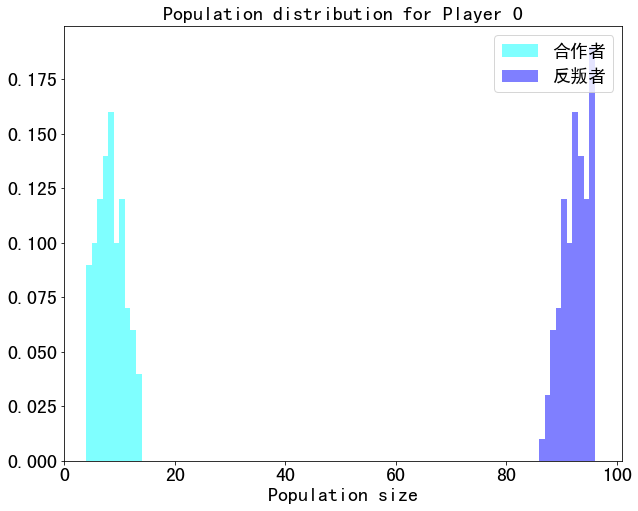

In [25]:
s = GameDynamicsWrapper(PrisonersDilemma,WrightFisher,dynamics_kwargs={'mu':[[0.1,0.1]]})
s.simulate_many(num_iterations=100,num_gens=100,histogram = True)

### 等高线图

我们可以通过改变两个报酬，例如囚徒困境中的R和T，来创建一个等高线图。
我们使用'vary_2params'辅助函数来改变游戏实例的两个参数。
只要T>R（根据囚徒困境的定义），叛逃总是主导合作，所以我们在等高线图（图3）中加入了T=R这条线作为参考。

当T>R时，该游戏是囚徒困境，"叛逃 "是唯一的纳什均衡。
当R>T，因为S<P，系统是双稳态的（Nowak，2006）。
在这种情况下，根据初始条件，系统要么收敛为合作，要么收敛为叛逃。


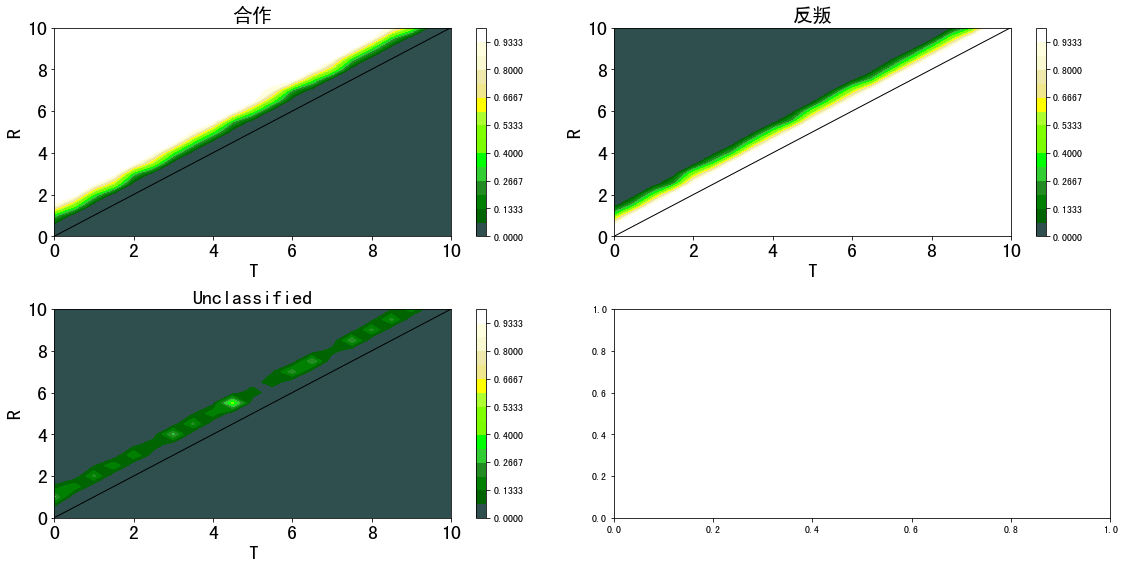

In [26]:
s = VariedGame(PrisonersDilemma, WrightFisher)
s.vary_2params('R', (0, 10, 20), 'T', (0, 10, 20), num_iterations = 50, num_gens = 100, graph = dict(type = 'contour', lineArray = [(0, 10, 0, 10)]))

图3：使用Wright-Fisher动力学改变参数R和T时的均衡分布的等高线图。
当T>R时，游戏是囚徒困境，"叛逃 "是唯一的纳什均衡。
未分类 "对应的是混合均衡，两种策略在群体中共存。
模拟运行了100代，每对R[0, 10]和T[0, 10]值的结果都是50次迭代的平均值。
黑色实线对应的是R=T。

## 三维导线图

我们还可以在改变博弈的2个参数时产生3D线框图（图4）。  
如上所述，改变R和T，代码中唯一的变化是指定要创建的图的类型。

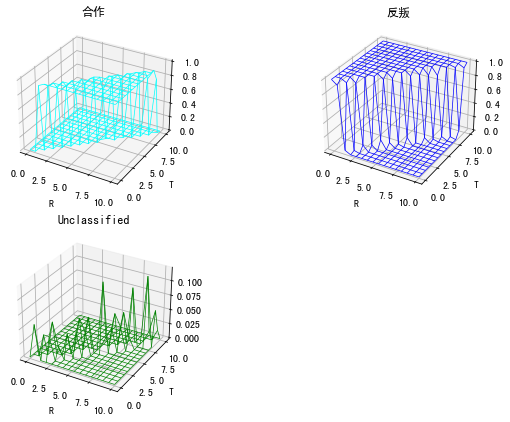

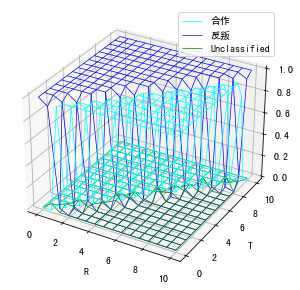

In [28]:
# s = VariedGame(PrisonersDilemma, WrightFisher)
# s.vary_2params('R', (0, 10, 15), 'T', (0, 10, 15), num_iterations = 50, num_gens = 100, graph = dict(type = '3 d', lineArray = [(0, 10, 0, 10)]))
s = VariedGame(PrisonersDilemma, WrightFisher)
s.vary_2params('R', (0, 10, 15), 'T', (0, 10, 15), num_iterations=50, num_gens=100, graph=dict(type='3d', lineArray=[(0, 10, 0, 10)]))

x和y轴对应于被改变的参数，而平衡比例则绘制在z轴上。
图4：使用Wright-Fisher动力学，在囚徒困境中改变R和T的平衡分布的三维线图。模拟运行了100代，每对R[0, 10]和T[0, 10]值的结果都是50次迭代的平均值。
